In [1]:
!nvidia-smi

Sun May 25 20:03:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports and Settings

In [5]:
import os
import sys
import csv
import pickle
import zipfile

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import PIL

from datetime import timedelta, datetime as dt
from time import time

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (LearningRateScheduler, ModelCheckpoint,
                                        EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import (EfficientNetB0, EfficientNetB3, 
                                           EfficientNetB4, EfficientNetB5, 
                                           EfficientNetB6, EfficientNetB7)
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
# Улучшим вид графиков в svg
%config InlineBackend.figure_format = 'svg'
%matplotlib inline


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print()

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)
GPU = tf.config.list_physical_devices('GPU')
print('GPU is', 'available' if GPU else 'NOT AVAILABLE')

/kaggle/input/mipt-bio-2025/fashion-mnist-testn/fmnist_test.csv
/kaggle/input/mipt-bio-2025/fashion-mnist-testn/sample_submission.csv
/kaggle/input/mipt-bio-2025/fashion-mnist-testn/fmnist_train.csv

Python       : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Numpy        : 1.26.4
Tensorflow   : 2.18.0
Keras        : 3.8.0
GPU is available


In [6]:
# Fix dependencies
!pip freeze > requirements.txt

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Input settings
IMG_SIZE = (28, 28)
NUM_CHANNELS = 1
NUM_CLASSES = 10

## Load Data

In [8]:
# Load data
DATA_PATH = '/kaggle/input/mipt-bio-2025/fashion-mnist-testn'
WORK_PATH = '/kaggle/working/'  # working dir
os.makedirs(WORK_PATH, exist_ok=True)

sample_submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

df_train = pd.read_csv(f'{DATA_PATH}/fmnist_train.csv')
df_test = pd.read_csv(f'{DATA_PATH}/fmnist_test.csv')

## EDA and Data Preprocessing

In [12]:
display(df_train.head())
print()
display(df_train.info())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Columns: 786 entries, label to Id
dtypes: float64(424), int64(362)
memory usage: 102.2 MB


None

In [13]:
# Remove nan rows
df_train = df_train.dropna()

Random samples:


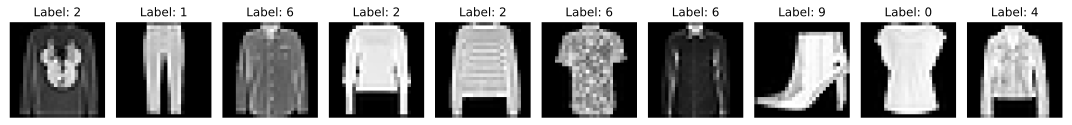

In [52]:
# Preview image samples

def plot_images(dataframe, n=10):
    random_samples = df_train.sample(n)
    random_samples = random_samples.apply(
        lambda r: (r.iloc[0], r.iloc[1:785].values.reshape(*IMG_SIZE)),
        axis=1
    )
    plt.figure(figsize=(15, 4))
    for i, sample in enumerate(random_samples):
        label, image = sample
        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {int(label)}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


print('Random samples:')
plot_images(df_train)

In [57]:
# Separate features and target
X = df_train.drop(columns=['label', 'Id'])
y = df_train['label']

# Normalize pixels
X = X / 255#.0
X_test = df_test.drop(columns=['Id']) / 255

# Train and validation subsets split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_SEED)

In [58]:
# Reshape for CNN input
_reshape = lambda x: x.values.reshape(-1, *IMG_SIZE, NUM_CHANNELS)

X_train, X_test, X_val = map(_reshape, [X_train, X_test, X_val])
 
# X_train = X_train.values.reshape(-1, 28, 28, 1)# / 255.0
# X_test = X_test.values.reshape(-1, 28, 28, 1)# / 255.0
# X_val = X_val.values.reshape(-1, 28, 28, 1)# / 255.0

## Model

In [59]:
# Use L2 regularization
l2_ = l2(0.001)


model = Sequential([
    Input(shape=(*IMG_SIZE, NUM_CHANNELS)), 
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2_), 
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2_),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2), 

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2_),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2_),
    BatchNormalization(),        
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3), 
    
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2_),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2_),
    BatchNormalization(),    
    MaxPooling2D(pool_size=(2, 2)),   
    Dropout(0.4), 
    
    Flatten(),  # 1D feature vector
    
    Dense(1024, activation='relu'),
    Dropout(0.3), 
    Dense(512, activation='relu'),
    Dropout(0.2), 
    
    Dense(NUM_CLASSES, activation='softmax')
])


# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001, weight_decay=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1748236792.478011      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,940,938 (7.40 MB)

 Trainable params: 1,939,146 (7.40 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Train

In [88]:
model.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=16, 
    validation_data=(X_val, y_val)
)

Epoch 1/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.5188 - loss: 2.0892 - val_accuracy: 0.7773 - val_loss: 1.2765
Epoch 2/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7721 - loss: 1.3268 - val_accuracy: 0.8298 - val_loss: 1.1303
Epoch 3/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8149 - loss: 1.1833 - val_accuracy: 0.8524 - val_loss: 1.0652
Epoch 4/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8498 - loss: 1.0882 - val_accuracy: 0.8606 - val_loss: 1.0181
Epoch 5/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8616 - loss: 1.0294 - val_accuracy: 0.8832 - val_loss: 0.9468
Epoch 6/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8772 - loss: 0.9772 - val_accuracy: 0.8756 - val_loss: 0.9409
Epoch 7/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8841 - loss: 0.9266 - val_accuracy: 0.8879 - val_loss: 0.8954
Epoch 8/150
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8934 - loss: 0.8825 - val_ac

## Predict

In [63]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## Submission

In [64]:
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'label': predicted_labels
})

# Save submission as CSV
submission.to_csv(f'{WORK_PATH}/submission.csv', index=False)

print('submission.csv ready!')

submission.csv ready!
